In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.measure
import numpy as np
import gc

img=mpimg.imread('../input/alaska2-image-steganalysis/Cover/00001.jpg')
imgplot = plt.imshow(img)
plt.title('Original')
plt.show()

test_pool = skimage.measure.block_reduce(img, (3,3,1), np.max)

imgplot = plt.imshow(test_pool)
plt.title('3*3 Pooling')
plt.show()

d1, d2, d3 = test_pool.shape
del test_pool
gc.collect()


U see ? it still make sense, almost nothing change ;)

after that we sum RGB colors, we flat the result and we apply dimension reduction using PCA and we give that food to lgbm for hyperparameters tuning.

in reality it gives that

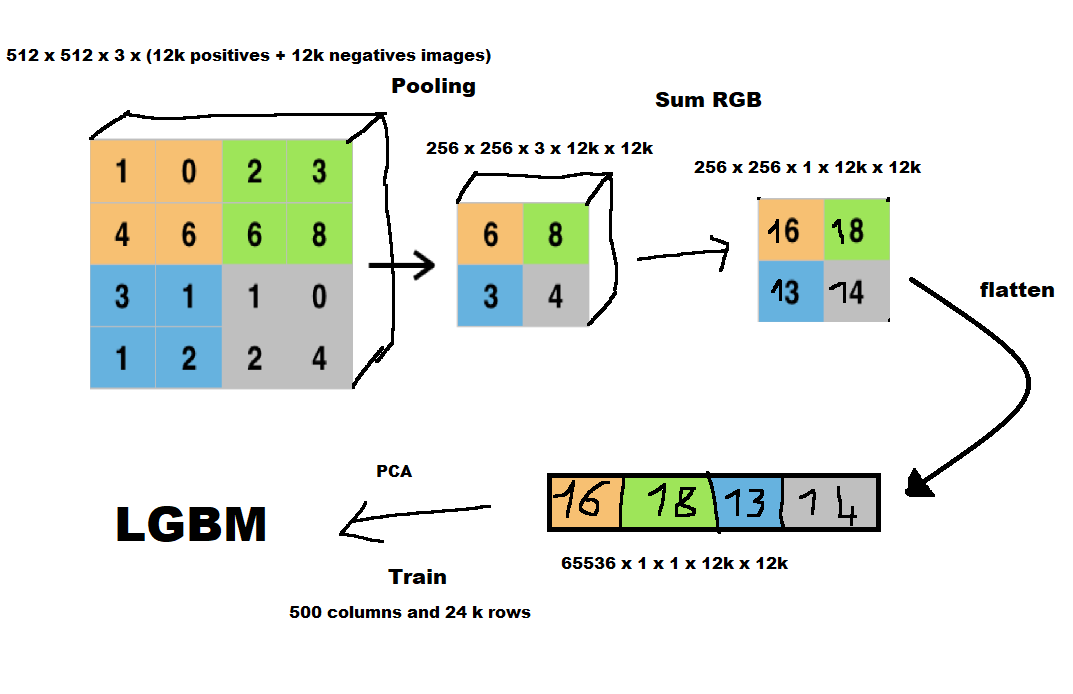

# Libraries for fun

In [ ]:
import pandas as pd
import tqdm
from PIL import Image
import glob
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Images Preprocess

I am gonna use 3 functions :

alaska_weighted_auc : Competition custom metric <a href="https://www.kaggle.com/anokas/weighted-auc-metric-updated">reference</a>

bayes_parameter_opt_lgb : useful for select best hyperparameters for lgb using bayesian optimisation <a href="https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm">reference</a>

img_reader : Import images and all process that I quoted above except PCA, made by me =D


In [ ]:
def alaska_weighted_auc(y_valid, y_true):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true.get_label(), y_valid, pos_label=1)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        if mask.sum() == 0:
            continue

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return 'alaska_weighted_auc' ,competition_metric / normalization, True

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, learning_rate, n_estimators):
        params = {'application':'binary', 'early_stopping_round':100, 'metric':'auc', 'objective' : 'binary'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['learning_rate'] = max(min(learning_rate, 1), 0.001)
        params['n_estimators'] = int(round(n_estimators))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'], feval = alaska_weighted_auc)
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.6, 1),
                                            'max_depth': (5, 20),
                                            'lambda_l1': (0, 10),
                                            'lambda_l2': (0, 10),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            'learning_rate' : (0.001, 0.1),
                                            'n_estimators' : (100, 10000)}, random_state=0)
    
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO

def img_reader(nbr_images = 10, df = None, file_name = 'Cover', from_ = 0, status = 'neg') :
    from_ = from_
    nbr_images  = nbr_images
    image_list = []
    i=0
    j=0
    df = df
    file_name = file_name
    for filename in tqdm.tqdm(glob.glob('../input/alaska2-image-steganalysis/'+file_name+'/*.jpg')): 
        if j >= from_ :
            im=mpimg.imread(filename)
            im=skimage.measure.block_reduce(im, (3,3,1), np.max)
            image_list.append(np.sum(im.reshape((d3, d1*d2)), axis = 0).tolist())
            i+=1
            if i%1000 == 0 :
                if df is None:
                    df = pd.DataFrame(image_list).astype('int16')
                    del image_list
                    gc.collect()
                    image_list = []
                else :
                    df = pd.concat([df , pd.DataFrame(image_list).astype('int16')])
                    del image_list
                    gc.collect()
                    image_list = []
                    if i == nbr_images :    
                        del image_list
                        gc.collect()
                        break
        j=j+1
        
    if status == 'neg' :
        df['output'] = 0
        df['output'] = df['output'].astype('int16')
        gc.collect()
    else :
        df['output'] = 1
        df['output'] = df['output'].astype('int16')
        gc.collect()
        
    return df

In [ ]:
img=mpimg.imread('../input/alaska2-image-steganalysis/Cover/00001.jpg')
test_pool = skimage.measure.block_reduce(img, (3,3,1), np.max)
d1, d2, d3 = test_pool.shape
del test_pool
gc.collect()

df_neg = img_reader(nbr_images = 12000, df = None, file_name = 'Cover', from_ = 0, status = 'neg')

df_pos = img_reader(nbr_images = 4000, df = None, file_name = 'JMiPOD', from_ = 0, status = 'pos')
print('JMiPOD Done!')
df_pos = img_reader(nbr_images = 4000, df = df_pos, file_name = 'JUNIWARD', from_ = 4000, status = 'pos')
print('JUNIWARD Done!')
df_pos = img_reader(nbr_images = 4000, df = df_pos, file_name = 'UERD', from_ = 8000, status = 'pos')
print('UERD Done!')

df_test = img_reader(nbr_images = 6000, df = None, file_name = 'Test', from_ = 0, status = 'neg')
print('Test Done!')

Save result as pkl format for later.

In [ ]:
df_train = pd.concat([df_pos, df_neg], ignore_index = True)
del df_pos, df_neg

df_train.to_pickle('df_train3*3.pkl')
df_test.to_pickle('df_test3*3.pkl')

del df_train, df_test
gc.collect()

In [ ]:
df_train = pd.read_pickle('./df_train3*3.pkl')
df_test = pd.read_pickle('./df_test3*3.pkl')

Apply PCA with 500 components

In [ ]:
pca1 = PCA(n_components=500)
df_train_pca = pca1.fit_transform(df_train.loc[:, df_train.columns != 'output'].values)

pca2 = PCA(n_components=500)
df_test_pca = pca2.fit_transform(df_test.loc[:, df_test.columns != 'output'].values)

In [ ]:
X = df_train_pca
y = df_train['output']
del df_train_pca ,
gc.collect()

# Hyperparameter Optimization

In [ ]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=30, n_folds=5, random_seed=6)

In [ ]:
print('Best Params :')

print(opt_params.max['params'])

# Train LGBM

In [ ]:
params = opt_params.max['params']
params['num_leaves'] = int(params['num_leaves'])
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])

d_train = lgb.Dataset(data=X, label=y, free_raw_data=False)

clf = lgb.train(params, train_set = d_train,  feval = alaska_weighted_auc)

In [ ]:
lgb.plot_importance(clf, max_num_features = 10)

In [ ]:
lgb.create_tree_digraph(clf)

# Predict and Submit

In [ ]:
y_pred=clf.predict(df_test_pca)
sub = pd.read_csv('../input/alaska2-image-steganalysis/sample_submission.csv')
sub['Label'] = y_pred
sub.to_csv('submission.csv', index=False)